In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="MdG0CEisqJkl0tDaWQuR")
project = rf.workspace("garbage-detection-oa9nh").project("yolov5-garbage-detection")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 16620, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 16620 (delta 55), reused 62 (delta 29), pack-reused 16522
Receiving objects: 100% (16620/16620), 15.10 MiB | 19.42 MiB/s, done.
Resolving deltas: 100% (11414/11414), done.


In [ ]:
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5


In [ ]:
%cd /
from glob import glob

test_img_list = glob('/content/yolov5_test_image_grabcut/*.jpg')

print(len(test_img_list))

/
20


In [ ]:
from IPython.display import Image
import os

%cd /content/yolov5/

# test_img_path = test_img_list[5]
# test_img_path = '/content/yolov5_test_image/image1.jpg'

# 결과 디렉토리 설정
result_dir = '/content/yolov5/runs/detect/exp/'

# 기존 결과 삭제
if os.path.exists(result_dir):
    import shutil
    shutil.rmtree(result_dir)

for i in range(len(test_img_list)):
    !python detect.py --weights /content/best.pt --img 320 --conf 0.25 --source {test_img_list[i]} --save-txt --save-conf --exist-ok
    Image(os.path.join('/content/yolov5/runs/detect/exp', os.path.basename(test_img_list[i])))

/content/yolov5
detect: weights=['/content/best.pt'], source=/content/yolov5_test_image_grabcut/test_trash6_result.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-313-g712de55a Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 322 layers, 86180143 parameters, 0 gradients, 203.8 GFLOPs
image 1/1 /content/yolov5_test_image_grabcut/test_trash6_result.jpg: 256x320 1 -, 213.7ms
Speed: 0.3ms pre-process, 213.7ms inference, 20.3ms NMS per image at shape (1, 3, 320, 320)
Results saved to runs/detect/exp
1 labels saved to runs/detect/exp/labels
detect: weights=['/content/best.pt'], source=/content/yolo

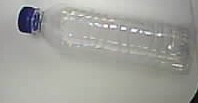

In [ ]:
import os
import cv2

# 이미지 경로와 결과 파일 경로 설정
image_path = '/content/yolov5_test_image/test_trash9.jpg'
txt_path = '/content/yolov5/runs/detect/exp/labels/test_trash9_result.txt'  # 이 경로는 실제 결과 파일에 맞게 조정 필요

# 이미지 로드
image = cv2.imread(image_path)
height, width, _ = image.shape

# 결과 파일 읽기
with open(txt_path, 'r') as file:
    lines = file.readlines()

# 객체 데이터 파싱
objects = []
for line in lines:
    parts = line.strip().split()
    x_center, y_center, bbox_width, bbox_height = map(float, parts[1:5])
    x_center *= width
    y_center *= height
    bbox_width *= width
    bbox_height *= height
    x1 = int(x_center - bbox_width / 2)
    y1 = int(y_center - bbox_height / 2)
    x2 = int(x_center + bbox_width / 2)
    y2 = int(y_center + bbox_height / 2)
    objects.append((x1, y1, x2, y2))

# 이미지 중앙과 가장 가까운 객체 찾기
image_center = (width / 2, height / 2)
closest_object = min(objects, key=lambda obj: (image_center[0] - (obj[0]+obj[2])/2) ** 2 + (image_center[1] - (obj[1]+obj[3])/2) ** 2)

# 가장 가까운 객체를 사용하여 이미지 크롭
x1, y1, x2, y2 = closest_object
cropped_image = image[y1:y2, x1:x2]

# 크롭된 이미지 저장 또는 표시
cv2.imwrite('/content/cropped_image.jpg', cropped_image)
# 또는
from IPython.display import display, Image
display(Image(data=cv2.imencode('.jpg', cropped_image)[1].tobytes()))



In [ ]:
import sys, os, glob
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
# from keras.utils import np_utils
from keras import utils
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def prepare_image(file_path, output_size=(384, 384)):
    # 이미지를 불러옵니다.
    img = cv2.imread(file_path)

    # 이미지 사이즈 조절
    desired_size = 275
    old_size = img.shape[:2]
    if max(old_size) < desired_size:
        ratio = float(desired_size) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        img = cv2.resize(cropped_image, (new_size[1], new_size[0]))


    h, w, _ = img.shape
    # 새 이미지의 크기를 설정합니다.
    new_h, new_w = output_size

    # 배경 이미지를 생성합니다. 여기서는 흰색 배경을 사용합니다.
    result = np.full((new_h, new_w, 3), 255, dtype=np.uint8)

    # 새 이미지에서 원본 이미지가 위치할 시작점을 계산합니다.
    x_center = (new_w - w) // 2
    y_center = (new_h - h) // 2

    # 원본 이미지를 새 이미지의 중앙에 위치시킵니다.
    result[y_center:y_center+h, x_center:x_center+w] = img

    # 이미지를 RGB 형식으로 변환합니다.
    img_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

    # 이미지를 numpy 배열로 변환합니다.
    img_array = image.img_to_array(img_rgb)

    # 데이터 형식을 float32로 변경합니다.
    img_array = img_array.astype('float32')

    # 차원을 확장하여 모델 입력에 맞춥니다.
    img_array = np.expand_dims(img_array, axis=0)

    # 입력 이미지 배열을 전처리합니다.
    img_array = preprocess_input(img_array)

    return img_array

In [ ]:
def classify_garbage(image_path):
    # 예를 들어 이미지 경로
    # img_path = './test_data/test4.jfif'

    # 이미지 전처리
    prepared_image = prepare_image(image_path)

    model = load_model("/content/cnn(batch_size_256_lr_e-3).h5", compile=False)

    class_names = open("/content/labels.txt", "r", encoding='UTF8').readlines()

    # 모델을 사용하여 예측
    predictions = model.predict(prepared_image)
    predicted_class = np.argmax(predictions, axis=1)[0]

    print("predicted_class:", predicted_class)

    class_name = class_names[predicted_class]
    garbage_class_name = class_name[2:-1]

    # print(f"Predicted class: {class_labels[predicted_class]}")

    return garbage_class_name, predicted_class

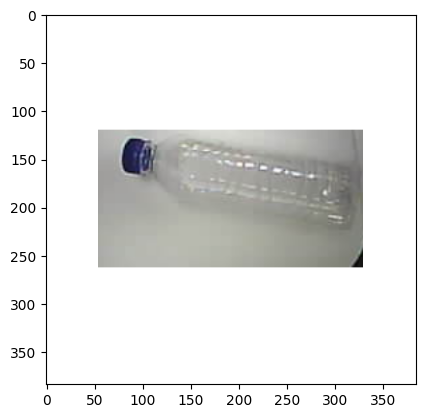

1/1 [==============================] - 1s 804ms/step
predicted_class: 3
종류: NORMAL
인덱스:  3


In [ ]:
class_name, class_idx = classify_garbage('/content/cropped_image.jpg')
print("종류: " + class_name)
print("인덱스: ", class_idx)